In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Библиотеки для обработки табличных данных
import pandas as pd
import numpy as np

# Библиотеки для визуализации графиков и изображений/
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Библиотеки для обучения моделей
import torch
from sklearn.model_selection import train_test_split

# Библиотека для работы с операционной системой
import os
import glob

# Библиотека для парсинга XML-файлов
import xml.etree.ElementTree as ET 

#Вспомогательные библиотеки
from tqdm.auto import tqdm
import shutil as sh
import warnings

# Игнорируем возникающие предупреждения
warnings.filterwarnings('ignore')

In [3]:
# Проверим, что нам доступна видеокарта
print(torch.cuda.is_available())
# Узнаем название видеокарты
print(torch.cuda.get_device_name(0))

True
Tesla P100-PCIE-16GB


In [4]:
!pwd

/kaggle/working


In [5]:
!ls "/kaggle/input/car-plate-detection/"

annotations  images


Для удобства зададим глобальные переменные с путями до нужных нам папок:

In [6]:
# Путь до папки с датасетом
DATASET_PATH = "/kaggle/input/car-plate-detection"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "images")

print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

/kaggle/input/car-plate-detection/annotations
/kaggle/input/car-plate-detection/images


Image shape: (398, 530, 3)


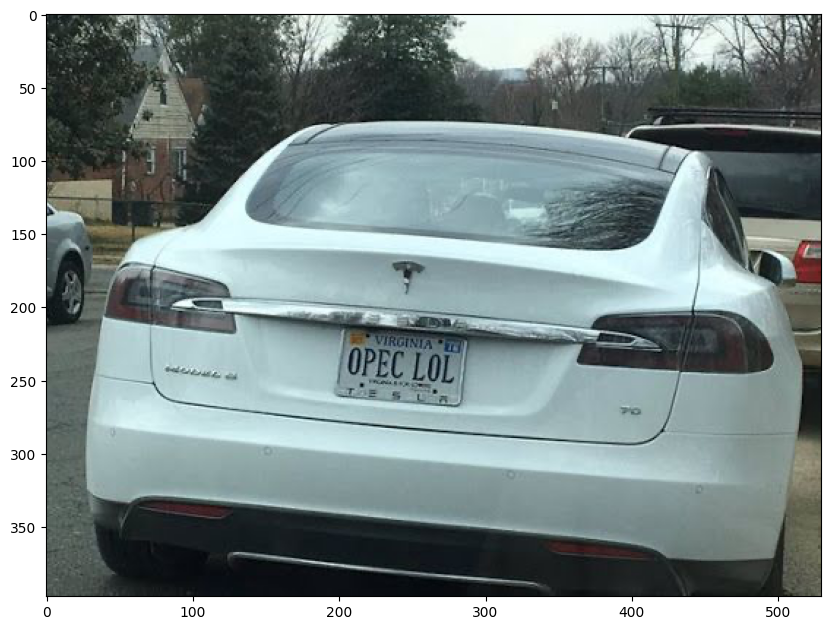

In [7]:
# Составляем путь до файла: /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);
# Выводим размер изображения
print('Image shape: {}'.format(img.shape))

Теперь давайте посмотрим на пример аннотации к этому изображению.

In [8]:
# Прочитаем один из файлов с аннотациями и посмотрим на его содержимое
with open(os.path.join(ANNOTATIONS_PATH, 'Cars129.xml')) as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cars129.png</filename>
    <size>
        <width>530</width>
        <height>398</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>204</xmin>
            <ymin>213</ymin>
            <xmax>282</xmax>
            <ymax>267</ymax>
        </bndbox>
    </object>
</annotation>


При использовании аннотации формата PASCAL VOC указываются следующие теги:
* <annotation> — корневой заголовок:
  + <folder> — папка с изображением,
  + <filename> — имя файла,
  + <size> — информация о размерах:
     - <width> — ширина,
     - <height> — высота,
     - <depth> — глубина (количество каналов).
  + <segmented> — информация для сегментации, то есть содержат ли изображения аннотации нелинейной (неправильной) формы, обычно называемые полигонами (у нас все рамки прямоугольные, поэтому стоит 0).
  + <object> — информация для детекции объектов:
     - <name> — имя класса (в нашем случае — номерной знак).
     - <pose> — асимметрия или ориентация изображения. По умолчанию имеет значение Unspecified (изображение не искажено).
     - <truncated> — видимость объекта (1 — полная или 0 — частичная).
     - <occluded> — информация о поглощении классов друг другом (когда внутри ограничивающего прямоугольника класса A есть ограничивающий прямоугольник класса B).
     - <difficult> — степень сложности распознавания объекта на изображении (0 — легко или 1 —сложно).
     - <bndbox> — координаты, которые определяют местоположение объекта (в нашем случае — номерного знака автомобиля). Эти координаты содержатся в дочерних тегах <xmin>, <ymin>, <xmax>, <ymax>. В аннотации хранятся координаты верхнего левого и нижнего правого положений объекта.

Из всего этого перечня нам понадобятся только поля filename, width, height, name и атрибуты bndbox. Другие поля также могут использоваться в некоторых задачах со сложной формой bounding box.

Для удобства дальнейшей работы создадим DataFrame, в котором будем хранить следующие столбцы:
* filename — имя файла (без расширения);
* xmin, xmax — минимальная и максимальная координата рамки по оси x;
* ymin, ymax — минимальная и максимальная координата рамки по оси y;
* width, height — ширина и высота изображения.

Для этого воспользуемся следующим кодом для парсинга XML-файлов с аннотациями:

In [9]:
# Инициализируем словарь, на основе которого затем создадим DataFrame
df_dict = {
    "filename":[], "xmin":[], "ymin":[],   
    "xmax":[],"ymax":[], "name":[],    
    "width":[], "height":[],
}

# Создаём цикл по всем аннотациям 
for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    # Читаем XML-файл с аннотацией
    tree = ET.parse(annotation)
    # Находим тег, соответствующий имени файла
    filename = tree.find('filename').text
    # Создаём цикл по всем элементам XML-файла
    for elem in tree.iter():
        # Извлекаем из аннотации информацию о размере изображения — ширину и высоту
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    
        # Извлекаем информацию об изображении — имя класса и информацию о координатах bounding box
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text                 
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height] 
                    df_dict['filename'] += [filename]


                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]

In [10]:
df = pd.DataFrame(df_dict)
df.head()

filename  xmin  ymin  xmax  ymax     name  width  height
0  Cars339.png   209   135   283   169  licence    500     300
1   Cars13.png   191   147   242   169  licence    400     268
2   Cars74.png   115   115   277   153  licence    400     267
3   Cars16.png    36   175    62   186  licence    400     221
4  Cars291.png    71   205   215   246  licence    517     303

Теперь нам будет очень удобно анализировать характеристики нашего датасета. Посмотрим на количество записей (аннотаций), уникальное количество изображений и уникальные классы в данных:

In [11]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))

Data shape: (471, 8)
Count of unique images: 433
Count of classes: ['licence']


Теперь, когда мы спарсили координаты bounding boxes, давайте выберем какое-нибудь изображение из датасета и отобразим его вместе с аннотацией, то есть добавим поверх изображения bounding box. Для этого воспользуемся классом Rectangle из модуля patches библиотеки Matplotlib — он позволяет задать прямоугольник и отобразить.

Также помним, что на одном изображении может быть сразу несколько bounding box, поэтому для корректной визуализации нам нужен цикл по всем координатам, соответствующим изображению.

[204] [213] [78] [54]


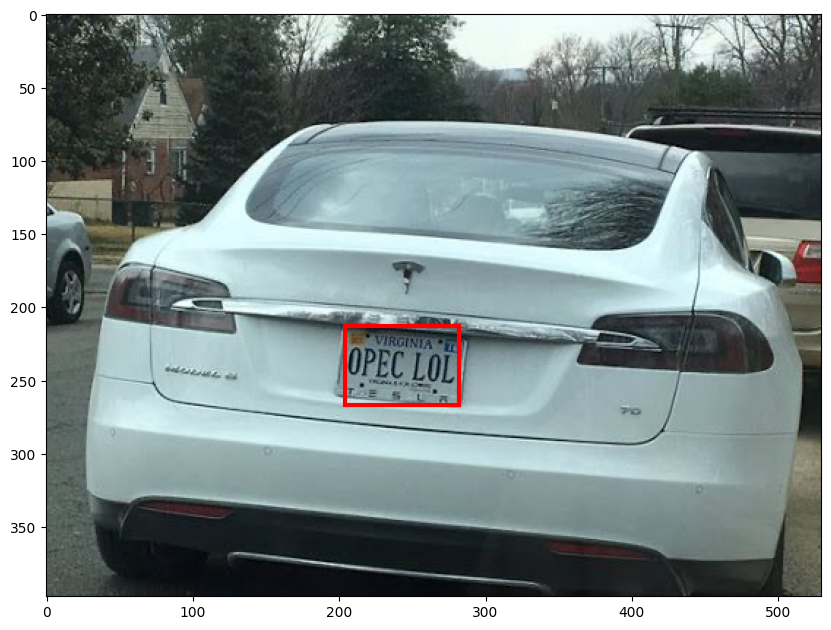

In [12]:
# Составляем путь до файла — /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);

# Находим индекс картинки в DataFrame
image_idx = df[df['filename'] == image_filename].index

# Находим координаты левой нижней точки
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
# Находим ширину и высоту рамки
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
print(x_min, y_min, box_width, box_height)

# Так как ограничивающих прямоугольников может быть несколько, создаём цикл по всем.
for i in range(len(image_idx)):
    # Строим прямоугольник
    rect = patches.Rectangle(
        (x_min[i], y_min[i]), #координаты опорной точки
        box_width[i], #ширина прямоугольника
        box_height[i], #высота прямоугольника
        linewidth=3, #ширина линии
        edgecolor='r', #цвет
        facecolor='none' #заливка (none — отсутствует)
    )
    # Накладываем прямоугольник поверх изображения
    ax.add_patch(rect);

Для удобства дальнейшей работы обернём весь этот код для визуализации изображений в функцию, назовём её plot_bounding_box(). Функция будет принимать название файла с нужным изображением и DataFrame с координатами и выводить изображение на экран:

In [13]:
def plot_bounding_box(image_folder, image_filename, df=df):
    # Создаём полный путь до изображения
    image_path = os.path.join(image_folder, image_filename)
    # Читаем изображение
    img = plt.imread(image_path)
    # Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize=(10, 8))
    # Выводим изображение на экран
    ax.imshow(img);

    # Находим индекс изображения в DataFrame
    image_idx = df[df['filename'] == image_filename].index

    # Находим координаты левой нижней точки
    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values
    # Находим ширину и высоту рамки
    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
    # Так как ограничивающих прямоугольников может быть несколько, создаём цикл по всем.
    for i in range(len(image_idx)):
        # Строим прямоугольник
        rect = patches.Rectangle(
            (x_min[i], y_min[i]), #координаты опорной точки
            box_width[i], #ширина прямоугольника
            box_height[i], #высота прямоугольника
            linewidth=3, #ширина линии
            edgecolor='r', #цвет
            facecolor='none' #заливка (none — отсутствует)
        )
        # Накладываем прямоугольник поверх изображения
        ax.add_patch(rect);

Проверим работу нашего кода для случая нескольких ограничивающих прямоугольников. Возьмём изображение 'Car330.png', подставим его название в аргумент image_filename функции plot_bounding_box() и получим:

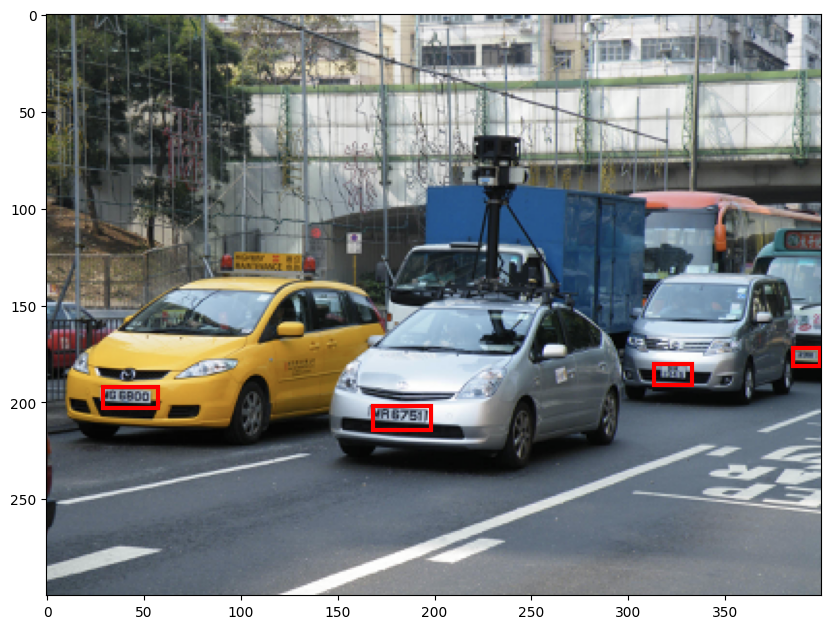

In [14]:
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='Cars330.png', df=df)

Вызовем функцию plot_bounding_box() несколько раз и посмотрим на изображения. Для примера вызовем функцию три раза на трёх случайных изображениях:

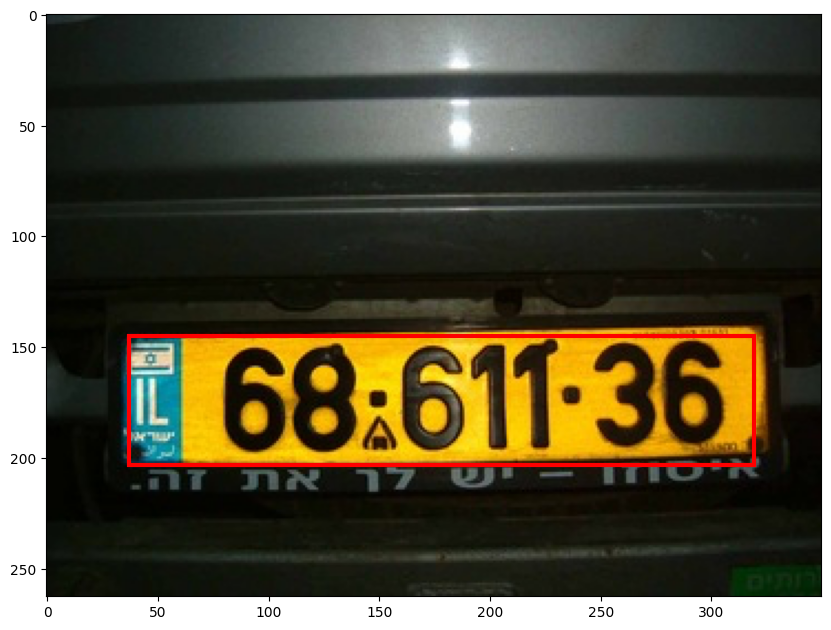

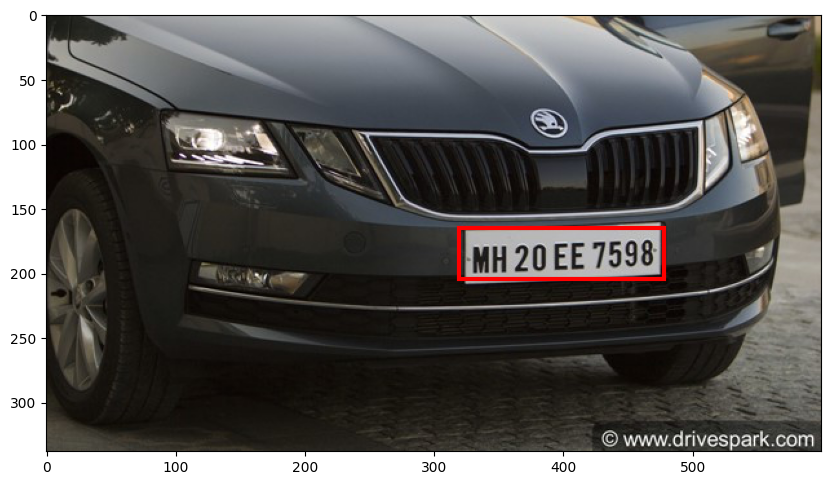

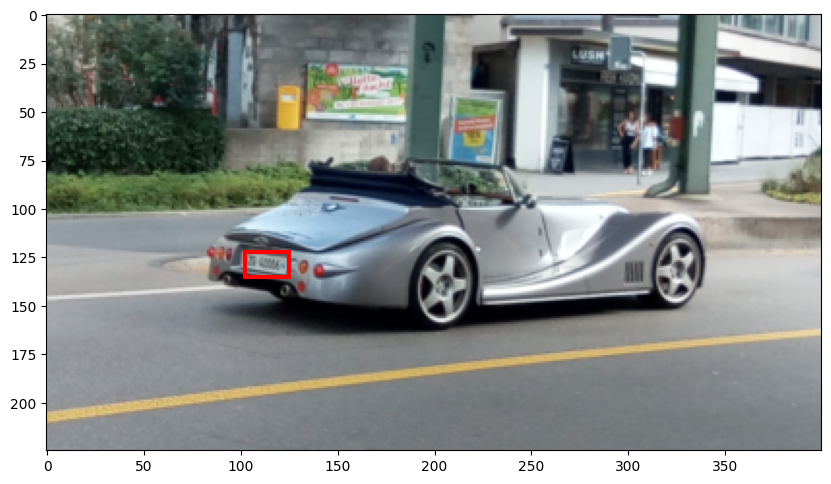

In [15]:
count = 3
for i in range(count):
    random_image_idx = np.random.choice(df.shape[0])
    image_filename = df.loc[random_image_idx, 'filename']
    plot_bounding_box(IMAGES_PATH, image_filename, df)

#### Подготавливаем данные под формат YOLOv5
Пример корневой директории датасета:\
* dataset
    + └─dataset.yaml
    + └─images
        - └─train
            * └─img1.png
            * └─img2.png
        - └─val
            * └─img3.png
            * └─img4.png
    + └─labels
        - └─train
            * └─img1.txt
            * └─img2.txt
        - └─val
            * └─img3.txt
            * └─img4.txt
            
#### Создание директории

In [16]:
DATA_PATH = "dataset/" # Корневая папка датасета

LABELS_PATH = os.path.join(DATA_PATH, "labels") # Папка с аннотациями
IMGS_PATH = os.path.join(DATA_PATH, "images") #Папка с изображениями

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train") #Путь до папки с обучающими изображениями
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val") #Путь до папки с валидационными изображениями
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train") #Путь до папки с обучающими аннотациями
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val") #Путь до папки с валидационными аннотациями

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml") #Путь до файла конфигураций данных

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

dataset/images/train
dataset/images/val
dataset/labels/train
dataset/labels/val
dataset/dataset.yaml


In [17]:
# Создаём локальную папку, в которую будем помещать изображения и аннотации к ним (если такая ещё не существует).
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Создаём папку, в которой будем хранить обучающие изображения (если такая ещё не существует).    
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)

# Создаём папку, в которой будем хранить обучающие аннотации к объектам (если такая еще не существует).
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)

# Создаём папку, в которой будем хранить валидационные изображения (если такая ещё не существует).
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)

# Создаём папку, в которой будем хранить валидационные аннотации к объектам (если такая ещё не существует).
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

In [18]:
# проверка структуры датасета
!ls dataset
!ls dataset/images
!ls dataset/labels

images	labels
train  val
train  val


Финальный шаг в подготовке директории: добавим файл конфигурации данных, назовём его dataset.yaml и пропишем в нём все пути, указанные выше:

In [19]:
# Создаём содержимое файла
data_config = f'''
path: /kaggle/working/dataset
train: images/train
val: images/val
test:
names:
    0: licence
'''

# Открываем на запись файл, в который записываем конфигурацию путей и из которого будут браться данные для обучения.
with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

# Проверяем, что всё записалось корректно.
with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: /kaggle/working/dataset
train: images/train
val: images/val
test:
names:
    0: licence



Теперь необходимо наполнить структуру содержанием — изображениями и аннотациями к ним.

Способы задать прямоугольник:
1) Указание рамки относительно верхней левой и нижней правой точек прямоугольника.\
Для задания такого bounding box нужны две точки:
 - (x1, y1) — координаты верхней левой точки;
 - (x2, y2) — координаты нижней правой точки.
 
2) Указание рамки относительно её центра.\
Для задания такого bounding box нужны следующие координаты:
- (x, y) — координаты центра прямоугольника;
- w — ширина прямоугольника;
- h — высота прямоугольника.

Для работы YOLOv5 от Ultralitics аннотации должны быть представлены в формате текстового файла (.txt). Формат подразумевает, что каждая строка файла представляется в виде:
$$n, \overline{x_c}, \overline{y_c} , \overline{w}, \overline{h}$$
* $n$ — номер класса объекта.
* $\overline{x_c}$ — относительная координата центра ограничивающего прямоугольника объекта по оси x.\
Она называется относительной, так как исходная координата центра нормируется на ширину изображения: $\overline{x_c} =\frac{x_c}{W}=\frac{x_1+x_2}{2W}$
* $\overline{y_c}$ — относительная координата центра ограничивающего прямоугольника объекта по оси y: $\overline{y_c} =\frac{y_c}{H}=\frac{y_1+y_2}{2H}$
* $\overline{w}$ относительная ширина ограничивающего прямоугольника объекта: $\overline{w} =\frac{w}{W}=\frac{x_2-x_1}{W}$
* $\overline{h}$ — относительная высота ограничивающего прямоугольника объекта: $\overline{h} =\frac{h}{H}=\frac{y_2-y_1}{H}$

**Перекодируем класс (linence) и рассчитаем новые координаты ограничивающих прямоугольников по заданным выше формулам:**

In [20]:
# Перекодируем классы
df['class'] = df['name'].map({'licence': 0})

# Вычисляем нормализованные координаты центра ограничивающего прямоугольника
df['x_center'] = (df['xmin'] + df['xmax']) / (2 * df['width'])
df['y_center'] = (df['ymin'] + df['ymax']) / (2 * df['height'])
# Вычисляем относительную высоту и ширину ограничивающего прямоугольника
df['box_width'] = (df['xmax'] - df['xmin']).abs() / df['width']
df['box_height'] = (df['ymax'] - df['ymin']).abs() / df['height']

# Смотрим на результаты
df[['class','x_center','y_center','box_width','box_height']].head()

class  x_center  y_center  box_width  box_height
0      0  0.492000  0.506667    0.14800    0.113333
1      0  0.541250  0.589552    0.12750    0.082090
2      0  0.490000  0.501873    0.40500    0.142322
3      0  0.122500  0.816742    0.06500    0.049774
4      0  0.276596  0.744224    0.27853    0.135314

Перед тем как производить запись новых координат в файлы, создадим обучающую и валидационную выборки: разделим все доступные нам изображения на две части в соотношении 90/10.\
На одном изображении может быть несколько ограничивающих прямоугольников. Это значит, что для создания выборок необходимы уникальные файлы, иначе в обучающую и валидационную выборки могут попасть одни и те же изображения и оценка модели по валидационной выборке получится необъективной.

In [21]:
# Создаём общий список названий файлов с изображениями
image_ids = list(set(df['filename']))
# Разделяем этот список на два — обучающую и валидационную выборки
train_ids, val_ids = train_test_split(image_ids, random_state=42, test_size=0.1)
# Смотрим на размеры выборок
print('Train shape: {}'.format(len(train_ids)))
print('Validation shape: {}'.format(len(val_ids)))

Train shape: 389
Validation shape: 44


Папки с аннотациями заполним txt-файлами с форматом данных, папки с изображениями — изображениями из соответствующих выборок.

In [22]:
# Создаём цикл по изображениям
for filename, mini in tqdm(df.groupby('filename')):
    # Если текущий файл находится в валидационной выборке
    if filename in val_ids:
        path2save = 'val'
    # В противном случае (тренировочная выборка)
    else:
        path2save = 'train'
    # Составляем путь до файла, в который запишем новую аннотацию.
    new_annotation_path = os.path.join(LABELS_PATH, path2save, filename[:-4] + ".txt")
    # Открываем на запись с добавлением (w+) файл формата .txt
    with open(new_annotation_path, 'w+') as f:
        # Выделяем координаты ограничивающего прямоугольника в требуемом для YOLOv5 формате
        row = mini[['class','x_center','y_center','box_width','box_height']].astype(float).values
        row = row.astype(str)
        # Построчно записываем координаты каждого из ограничивающих прямоугольников на изображении
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
    # Переносим изображения из исходной папки в новую папку
    sh.copy(
        os.path.join(IMAGES_PATH, filename),
        os.path.join(IMGS_PATH, path2save, filename)
    )

  0%|          | 0/433 [00:00<?, ?it/s]

Посмотрим, что у нас получилось. С помощью функции listdir() из модуля os выведем список из 30 файлов в директориях обучающей выборки 'dataset/labels/train/' и 'dataset/images/train/':

In [23]:
print(os.listdir(TRAIN_LABELS_PATH)[:30])
print(os.listdir(TRAIN_IMAGES_PATH)[:30])

['Cars296.txt', 'Cars282.txt', 'Cars141.txt', 'Cars160.txt', 'Cars193.txt', 'Cars266.txt', 'Cars3.txt', 'Cars281.txt', 'Cars233.txt', 'Cars284.txt', 'Cars285.txt', 'Cars78.txt', 'Cars236.txt', 'Cars426.txt', 'Cars347.txt', 'Cars218.txt', 'Cars51.txt', 'Cars404.txt', 'Cars415.txt', 'Cars12.txt', 'Cars403.txt', 'Cars274.txt', 'Cars2.txt', 'Cars217.txt', 'Cars386.txt', 'Cars226.txt', 'Cars13.txt', 'Cars120.txt', 'Cars18.txt', 'Cars30.txt']
['Cars84.png', 'Cars243.png', 'Cars360.png', 'Cars91.png', 'Cars367.png', 'Cars81.png', 'Cars321.png', 'Cars36.png', 'Cars209.png', 'Cars204.png', 'Cars297.png', 'Cars127.png', 'Cars240.png', 'Cars405.png', 'Cars21.png', 'Cars312.png', 'Cars73.png', 'Cars230.png', 'Cars158.png', 'Cars199.png', 'Cars72.png', 'Cars244.png', 'Cars423.png', 'Cars178.png', 'Cars227.png', 'Cars425.png', 'Cars224.png', 'Cars152.png', 'Cars144.png', 'Cars18.png']


Посмотрим, как выглядят наши аннотации, на примере файла 'Car277.txt':

0.0 0.15 0.761168384879725 0.06 0.024054982817869417
0.0 0.35875 0.7577319587628866 0.0475 0.024054982817869417
0.0 0.7475 0.7714776632302406 0.045 0.030927835051546393
0.0 0.95125 0.7371134020618557 0.0375 0.01718213058419244



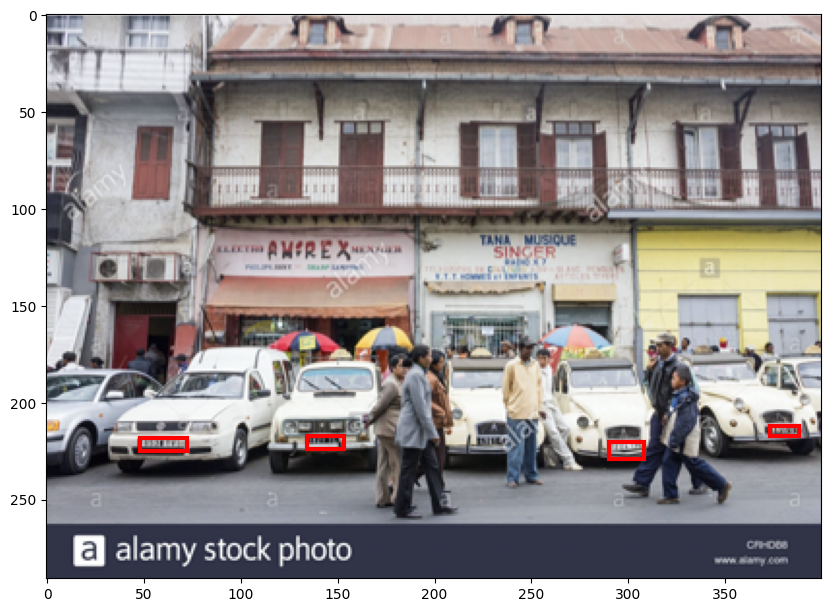

In [24]:
# Открываем файл с аннотацией и читаем содержимое
with open(os.path.join(TRAIN_LABELS_PATH, 'Cars277.txt')) as f:
    txt_example = f.read()
# Выводим содержимое на экран
print(txt_example)
# Смотрим на само изображение
plot_bounding_box(TRAIN_IMAGES_PATH, 'Cars277.png', df)


Проверим, что количество аннотаций совпадает с количеством изображений в каждой выборке:

In [25]:
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


**Давайте клонируем репозиторий с YOLOv5 и установим необходимые для её работы зависимости**

In [26]:
# Клонируем репозиторий с моделью YOLO-v5
!git clone https://github.com/ultralytics/yolov5
# Устанавливаем зависимости, необходимые для работы модели
!pip install -qr yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16953, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 16953 (delta 75), reused 99 (delta 49), pack-reused 16805 (from 1)
Receiving objects: 100% (16953/16953), 15.70 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (11604/11604), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible.


In [27]:
!ls yolov5

CITATION.cff	 README.zh-CN.md  detect.py   pyproject.toml	tutorial.ipynb
CONTRIBUTING.md  benchmarks.py	  export.py   requirements.txt	utils
LICENSE		 classify	  hubconf.py  segment		val.py
README.md	 data		  models      train.py


В папке yolov5 хранятся файлы из репозитория. В частности, нам интересны следующие папки/скрипты:
* data — папка с некоторыми классическими датасетами;
* models — папка с предобученными весами модели, которые можно использовать, чтобы не обучать модель с нуля;
* train.py — скрипт для обучения модели;
* val.py — скрипт для валидации модели;
* tutorial.ipynb — ноутбук с обучающими материалами по использованию модели;
* utils — модуль с полезными утилитами, которые могут понадобиться при работе с моделью.

Давайте зафиксируем датчик генератора случайных чисел, чтобы в дальнейшем получать воспроизводимые результаты. Для этого служит функция init_seeds() в модуле utils.general репозитория yolov5. В неё можно передать любое число. Чтобы корректно вызвать эту функцию, необходимо перейти в директорию yolov5 с помощью функции os.chdir() из модуля os.

In [28]:
# Перемещаемся в директорию yolov5
os.chdir('yolov5')
# Импортируем оттуда функцию init_seeds
from utils.general import init_seeds
#Фиксируем генератор случайных чисел для воспроизводимости результатов
RANDOM_STATE = 42
init_seeds(RANDOM_STATE)
# Возвращаемся в рабочую директорию
os.chdir('../')

Во время обучения модели YOLOv5 от Ultralitics для сохранения процесса обучения используется инструмент Weights & Biases (W & B).

Так как мы не регистрировались заранее, воспользуемся анонимным аккаунтом. Для авторизации надо установить библиотеку wandb и вызвать из неё функцию login.

In [29]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Обучение модели
Для обучения модели предназначен скрипт train.py в репозитории yolov5. Для его запуска необходимо указать следующие ключи:
* --img — размер изображения, подаваемого на вход YOLOv5. Это значит, что размер исходного изображения преобразуется к виду n x n, где n — число, введённое пользователем после ключа --img.  n должно быть кратно 32. Число 32 в данном случае — это размер одного сегмента.
* --batch — размер батча, то есть число изображений, подаваемых в сеть за один шаг обучения.
* --epochs — количество эпох обучения.
* --data — путь до файла формата .yaml, который мы создавали ранее.
* --weights — предобученные веса, используемые моделью.
* --name — имя папки, куда сохраняем результаты обучения.

Ключ --weights отвечает за выбор предобученной модели. На практике мы почти всегда используем предобученную на другом датасете модель и адаптируем её под нашу задачу. В частности модель YOLOv5 предобучена на популярном датасете COCO, в котором используется 80 различных классов объектов, например, люди, собаки, самолёты, автомобили.\
Среди этих классов не найдётся нашего (номерной знак транспортного средства), однако мы можем использовать паттерны и шаблоны, усвоенные во время обучения на датасете COCO, и адаптировать их под нашу задачу.

Давайте последуем совету разработчиков и воспользуемся версией small (s) модели YOLOv5. Будем обучать модель на изображениях размером 640 x 640, количество эпох — 30 (epochs), на одну итерацию градиентного спуска будем отдавать десять изображений (batch_size). Также укажем путь до файла с конфигурацией данных (data), путь до весов модели (weights) и имя папки, куда нужно сохранить результат (name).

In [30]:
# Запускаем файл train.py со скриптом для обучения модели
!python yolov5/train.py \
--img 640 \
--batch 10 \
--epochs 30 \
--data {DATA_CONFIG_PATH} \
--weights yolov5s.pt \
--name my_yolov5_model_s

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: anony-moose-533348609108523718. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=dataset/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=my_yolov5_model_s, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up

**История обучения модели**

In [31]:
!ls yolov5/runs/train/my_yolov5_model_s/

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1725806778.c9999ae6926b.101.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


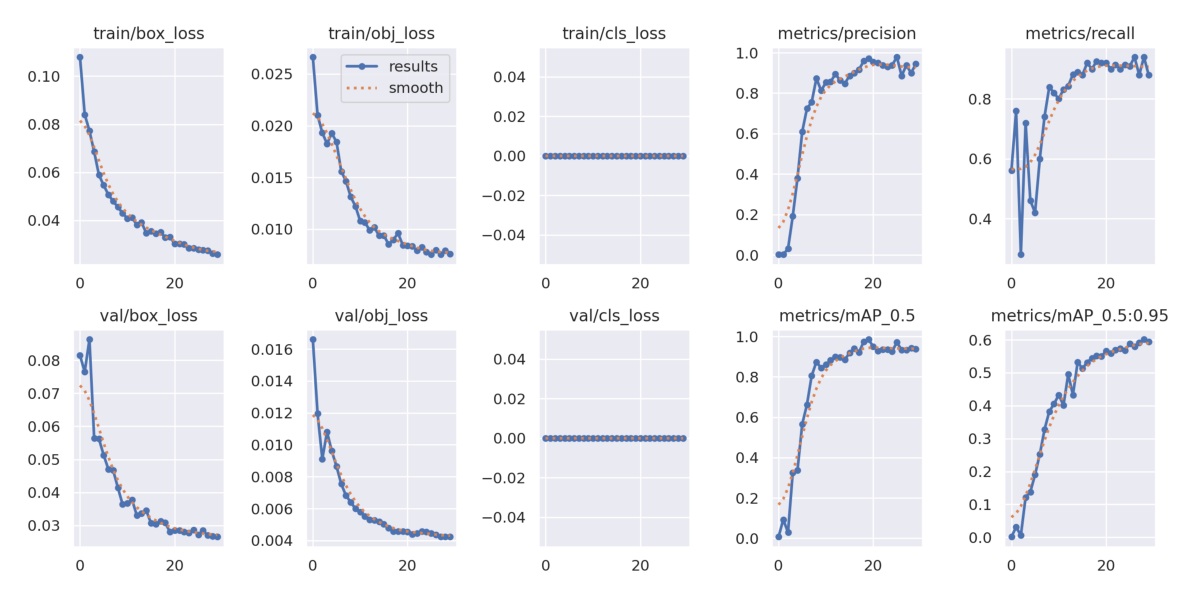

In [32]:
# Читаем файл с графиками процесса обучения
results = plt.imread('yolov5/runs/train/my_yolov5_model_s/results.png')
# Отображаем графики
fig, ax = plt.subplots(figsize=(15,12))
ax.axis('off')
ax.imshow(results);

В папке runs/result/weights хранятся два файла с весами (параметрами нейронной сети):
* best.pt — файл, в котором сохранён лучший вариант параметров модели за всё время обучения;
* last.pt — файл, в котором сохранены веса, которые модель получила на последней эпохе обучения.

In [33]:
!ls yolov5/runs/train/my_yolov5_model_s/weights

best.pt  last.pt


Загрузим лучшие веса в нашу модель. с помощью функции load() из модуля hub библиотеки PyTorch, которая позволяет автоматически загружать модели из репозиториев на GitHub или локальных директорий и «наполнять» их значениями параметров из файлов:
* repo_or_dir — путь до директории и репозитория, где хранится модель. У нас это директория yolov5.
* model — имя модели. В YOLOv5 все пользовательские модели обозначаются как 'custom'.
* path — путь до весов модели. Указываем путь до файла best.pt.
* source — может иметь значение 'local' (если модель берётся из локальной директории) или 'github' (если модель скачивается с GitHub). У нас всё уже загружено в рабочую папку, поэтому ставим 'local'.

In [34]:
# Путь до места, где хранятся лучшие веса.
BEST_WEIGHTS_PATH = 'yolov5/runs/train/my_yolov5_model_s/weights/best.pt'
# Загружаем лучшие веса
yolov5 = torch.hub.load(
    repo_or_dir='yolov5',
    model='custom',
    path=BEST_WEIGHTS_PATH,
    source='local'
)

YOLOv5 🚀 v7.0-365-g12b577c8 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


#### Прверка работы модели

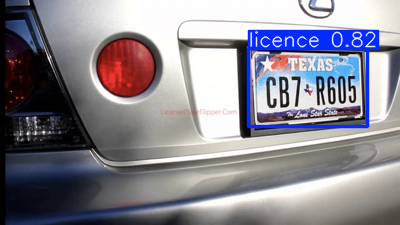

In [35]:
# Путь до изображения
image_filename = 'Cars351.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем изображение через модель
prediction = yolov5(image_path)
# Отображаем результат
prediction.show()

Число рядом с классом - *Confidence*, может иметь значение от 0 до 1 и характеризует «уверенность» модели в том, что данный объект принадлежит к определённому классу.

Проверим, что модель способна определять сразу несколько номерных знаков. 

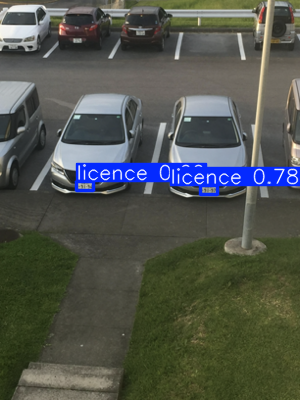

In [36]:
# Путь до изображения
image_filename = 'Cars352.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем изображение через модель
prediction = yolov5(image_path)
# Отображаем результат
prediction.show()

In [37]:
# конвертируем результат в DataFrame с помощью функции pandas()
prediction.pandas().xyxy[0]

xmin        ymin        xmax        ymax  confidence  class     name
0  200.871094  185.180649  217.357208  194.742035    0.782826      0  licence
1   76.791656  181.310745   93.508133  190.589996    0.596276      0  licence

YOLOv5 модель предоставляет встроенный метод crop(), который возвращает список из словарей, каждый из которых характеризует отдельно взятый ограничивающий прямоугольник: его координаты ("box"), confidence rate ("confidence"), номер класса объекта ("class"), название класса ("label") и само вырезанное изображение ("im").

Например, отбрасим вырезки, confidence rate которых < 0.7:

In [38]:
# Путь до изображения
image_filename = 'Cars351.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем изображение через модель
prediction = yolov5(image_path)
# Делаем вырезки из изображения
croped = prediction.crop()
# Создаём цикл по каждой вырезке
for pred in croped:
    # Отсекаем такие ограничивающие прямоугольники, confidence rate которых < 0.7
    if pred['conf'] < 0.7:
        continue
    # Извлекаем вырезанное изображение
    img_croped = pred['im']
    # Визуализируем результат
    fig = plt.figure()
    plt.imshow(img_croped)

Saved 1 image to runs/detect/exp
Saved results to runs/detect/exp



Итак, упакуем предсказания модели для каждого изображения из исходного датасета в таблицу. Для этого пройдём циклом по всем изображениям из датасета и соединим все предсказания в один DataFrame. Будем отбрасывать такие ограничивающие прямоугольники, confidence для которых < 0.7.

In [39]:
# Список всех файлов с изображениями
filenames = df['filename']
# Создаём пустой DataFrame
pred_df = pd.DataFrame()
# Создаём цикл по всем файлам
for filename in tqdm(filenames):
    # Составляем путь до изображения
    image_path = os.path.join(IMAGES_PATH, filename)
    # Пропускаем изображение через модель
    prediction = yolov5(image_path)
    # Конвертируем предсказания в DataFrame
    pred_rows = prediction.pandas().xyxy[0]
    # Оставляем ограничивающие прямоугольники, confidence которых > 0.7
    pred_rows = pred_rows[pred_rows['confidence'] > 0.7]
    # Добавляем в DataFrame столбец с именем файла
    pred_rows['filename'] = filename
    # Соединяем полученный DataFrame с общей таблицей
    pred_df = pd.concat([pred_rows, pred_df], axis=0)
# Сбрасываем индекс
pred_df = pred_df.reset_index(drop=True)    
pred_df.head()

  0%|          | 0/471 [00:00<?, ?it/s]

xmin        ymin        xmax        ymax  confidence class     name  \
0   43.534843  224.371414  139.735764  248.190842    0.844382     0  licence   
1  156.190643  148.841461  243.886948  170.066757    0.811605     0  licence   
2  222.353485  180.903244  324.962921  210.144958    0.856905     0  licence   
3  149.180069  123.434608  200.570450  149.602188    0.852260     0  licence   
4  269.909027  124.403961  325.077759  139.020966    0.834790     0  licence   

      filename  
0  Cars349.png  
1  Cars297.png  
2   Cars52.png  
3  Cars166.png  
4  Cars340.png

In [40]:
#Сохраняем полученные предсказания в виде таблицы
pred_df.to_csv('dataset/yolov5_predictions.csv', index=False)